In [110]:
import scipy.io
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import pandas as pd

# Loading the data

In [111]:
data_path = "./data/"

ARDS_data = scipy.io.loadmat(data_path + "Ards.mat")
Control_data = scipy.io.loadmat(data_path + "Control.mat")

ARDS_data = {key: ARDS_data[key][0] for key in ["P", "Q", "V", "t"]}
Control_data = {key: Control_data[key][0] for key in ["P", "Q", "V", "t"]}

# Part 1 : make plots of the differents curves

In [112]:
def plot_time_curve(X, Y, t, alpha_value = 0.5, x_label = "X", y_label ="Y", grid = True, title = "Time curve", x_lim=None, y_lim=None, line = False):
    # Create a colormap that represents the gradient of time
    cmap = plt.cm.jet  # You can choose any colormap you prefer
    norm = plt.Normalize(min(t), max(t))
    ncolors = len(t)  # Number of colors should match the number of time points
    colors = cmap(norm(t))

    # Create a list of segments for the LineCollection
    points = np.array([X, Y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a LineCollection object with a color gradient
    lc = LineCollection(segments, cmap=ListedColormap(colors), norm=BoundaryNorm(t, ncolors), linewidth=2, alpha=alpha_value)
    lc.set_array(t)

    minX = np.argmin(X)
    maxX = np.argmax(X)



    # Plot the trajectory
    fig, ax = plt.subplots()
    ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)
    plt.colorbar(lc, label='Time')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    if line:
        ax.plot([X[minX], X[maxX]],  [Y[minX], Y[maxX]])
    if grid:
        plt.grid()
    if x_lim is not None:
        plt.xlim(x_lim)
    if y_lim is not None:
        plt.ylim(y_lim)
    plt.show()

def plot_time_curves_patient(data, title="Data"):
    P = data['P']
    V = data['V']
    Q = data['Q']
    t = data['t'] - data['t'][0]

    plot_time_curve(P, V, t, title = title + " P-V curve", x_label="P [cmH2O]", y_label="V [l]" , line = True, grid=True, x_lim=[-0.5, 45], y_lim=[-0.05, 0.35])
    plot_time_curve(V, Q, t, title = title + " V-Q curve", x_label="V [l]", y_label="Q [l/s]", grid=True, y_lim=[-0.9, 0.6], x_lim=[-0.05, 0.35])

In [113]:
#plot_time_curves_patient(Control_data, "Control Patient")
#plot_time_curves_patient(ARDS_data, "ARDS Patient")

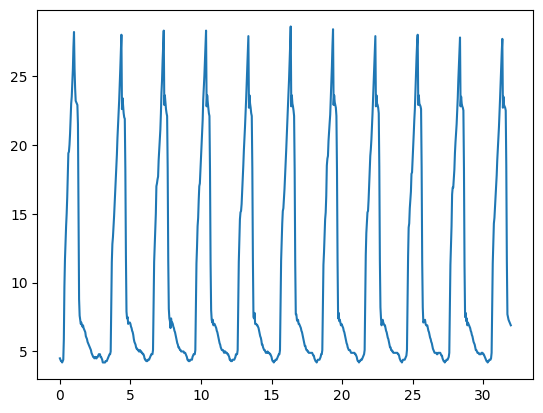

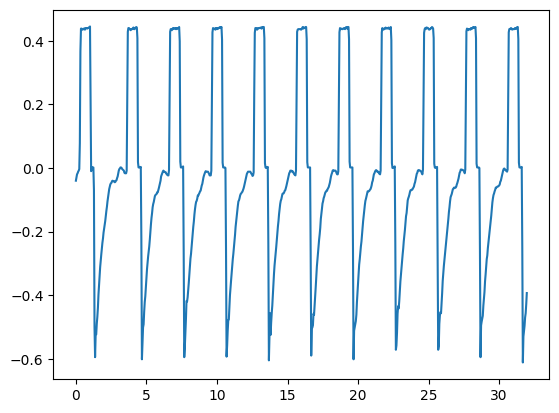

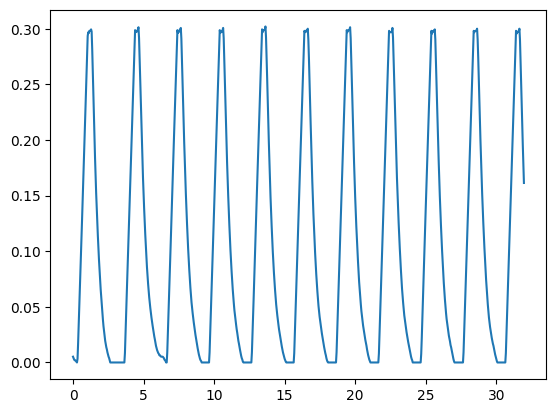

In [114]:
plt.figure()
plt.plot(Control_data['t'] - Control_data['t'][0], Control_data['P'], label="Control data")
plt.figure()
plt.plot(Control_data['t'] - Control_data['t'][0], Control_data['Q'], label="Control data")

plt.figure()
plt.plot(Control_data['t'] - Control_data['t'][0], Control_data['V'], label="Control data")

In [115]:
def extract_cycles(data):
    cycles = []

    t = data['t']
    P = data['P']
    Q = data['Q']
    V = data['V']

    zero_V_indices = np.argwhere(V == 0).flatten()
    filtered_V_indices = []

    if len(zero_V_indices) == 0:
        print("Not a proper curve ! Never cross V = 0")
        exit(-1)

    filtered_V_indices.append(zero_V_indices[0])

    V_sequence = [zero_V_indices[0]]

    for i in range(1, len(zero_V_indices)):
        
        if zero_V_indices[i] != zero_V_indices[i-1] + 1:
            filtered_V_indices.append(V_sequence[len(V_sequence)//2])
            V_sequence = []

        V_sequence.append(zero_V_indices[i])
    
    filtered_V_indices.append(V_sequence[len(V_sequence)//2])
        
    for i in range(0, len(filtered_V_indices) - 1):
        cycles.append({'t' : t[filtered_V_indices[i]:filtered_V_indices[i+1]+1] - t[filtered_V_indices[i]],
                       'P' : P[filtered_V_indices[i]:filtered_V_indices[i+1]+1],
                       'Q' : Q[filtered_V_indices[i]:filtered_V_indices[i+1]+1],
                       'V' : V[filtered_V_indices[i]:filtered_V_indices[i+1]+1]})
                       

    return cycles
"""
for c, d in enumerate(extract_cycles(Control_data)):

    fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'xticks': [], 'yticks': []})

    # Plot on each subplot
    for ax, data_type in zip(axs, ['V', 'P', 'Q']):
        ax.plot(d['t'], d[data_type])
        ax.set_title(data_type)

    plt.suptitle(f"Cycle {c + 1}", y=1.05)
    plt.tight_layout()
    plt.show()

    plot_time_curves_patient(d, f"Control Patient - Cycle {c+1} - ")
"""
    

'\nfor c, d in enumerate(extract_cycles(Control_data)):\n\n    fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={\'xticks\': [], \'yticks\': []})\n\n    # Plot on each subplot\n    for ax, data_type in zip(axs, [\'V\', \'P\', \'Q\']):\n        ax.plot(d[\'t\'], d[data_type])\n        ax.set_title(data_type)\n\n    plt.suptitle(f"Cycle {c + 1}", y=1.05)\n    plt.tight_layout()\n    plt.show()\n\n    plot_time_curves_patient(d, f"Control Patient - Cycle {c+1} - ")\n'

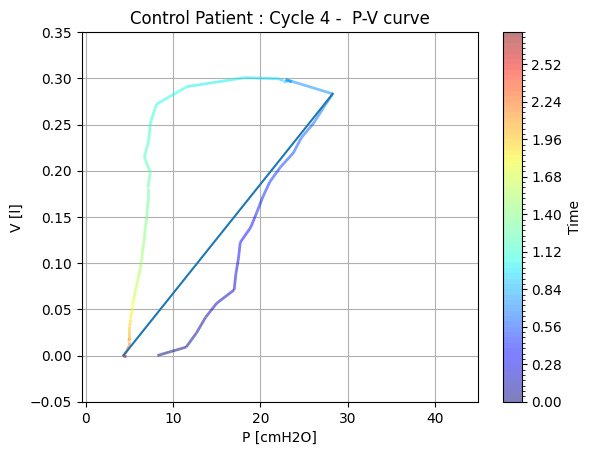

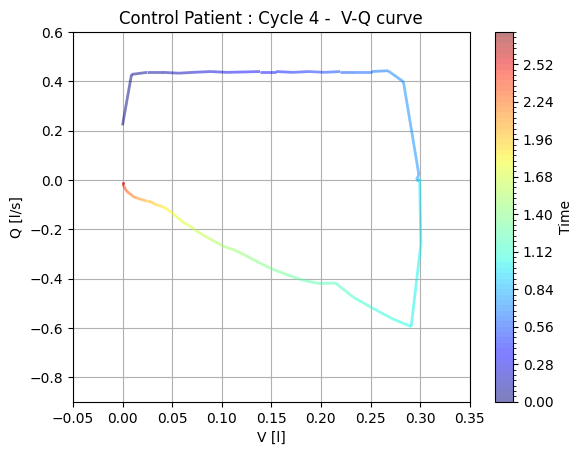

43.10607


In [116]:
d = extract_cycles(Control_data)[3]
plot_time_curves_patient(d, "Control Patient : Cycle 4 - ")

WOB = np.trapz(Control_data['P'], Control_data['V'])
print(WOB)
X = Control_data['P']
Y = Control_data['V']


In [117]:
from scipy.interpolate import interp1d

def from_data_get_interpolate(data):
    t = data['t']
    V = data['V']
    P = data['P']
    Q = data['Q']

    t_span = [min(t), max(t)]

    V_interp = interp1d(t, V, kind='linear', fill_value='extrapolate')
    P_interp = interp1d(t, P, kind='linear', fill_value='extrapolate')
    Q_interp = interp1d(t, Q, kind='linear', fill_value='extrapolate')

    return t_span, V_interp, P_interp, Q_interp


In [118]:
from sklearn.linear_model import LinearRegression

def model(t, Ers, V, Rrs, Q, P0):
    return Ers*V(t) + Rrs * Q(t) + P0

def estimate_parameters(data):
    V = data['V']
    P = data['P']
    Q = data['Q']

    X = np.array([V, Q]).T
    Y = np.array(P)

    model = LinearRegression().fit(X, Y)
    
    Ers = model.coef_[0]
    Rrs = model.coef_[1]
    P0 = model.intercept_

    R_squared = model.score(X, Y)

    return Ers, Rrs, P0, R_squared

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


def get_lung_properties(data):
    cycles = extract_cycles(data)
    #create a pandas dataframe with Ers, Rrs, P0, R_squared
    properties = pd.DataFrame(columns=['Ers', 'Rrs', 'P0', 'R_squared'])
    for c, d in enumerate(cycles):
        Ers, Rrs, P0, R_squared = estimate_parameters(d)
        properties.loc[c] = [Ers, Rrs, P0, R_squared]
    return properties

control_properties = get_lung_properties(Control_data)
#compute Q25, Q50 and Q75 and put in a dataframe
med_control_properties = control_properties.quantile([0.25, 0.5, 0.75])
ARDS_properties = get_lung_properties(ARDS_data)
med_ards_properties = ARDS_properties.quantile([0.25, 0.5, 0.75])
#print(control_properties)
#print(ARDS_properties)

print(min(control_properties['R_squared']), max(control_properties['R_squared']))
print(med_control_properties)
print(min(ARDS_properties['R_squared']), max(ARDS_properties['R_squared']))
print(med_ards_properties)

nan nan
            Ers        Rrs        P0  R_squared
0.25  54.669856  16.543839  4.727209   0.984238
0.50  55.185883  16.776226  4.778684   0.984678
0.75  55.353758  16.968404  4.838666   0.985310
0.902347959321121 0.9873047760528912
             Ers        Rrs        P0  R_squared
0.25  103.781557  25.962304  5.135653   0.983713
0.50  104.567135  26.192151  5.197244   0.985525
0.75  104.972668  26.545248  5.315173   0.987069


/home/julienbrandoit/classic_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


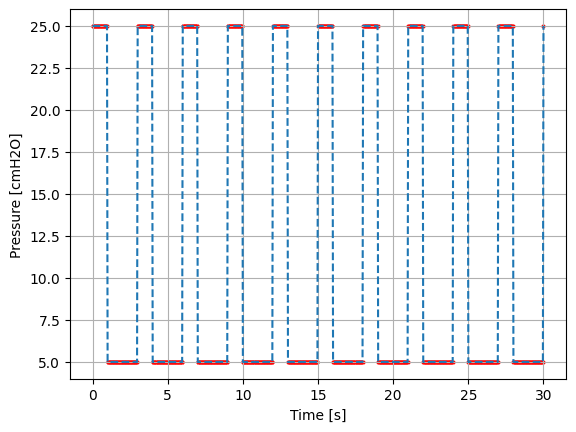

In [119]:
def square_wave(t, p_max=20, p_min=0, PEEP=5, BR_per_min=20, exp_ratio=2/3):
    # Compute the period of the square wave
    T = 60 / BR_per_min

    # Compute the time in the period
    t = t % T

    # Compute the time in the inspiration
    t_insp = T * (1-exp_ratio)

    # Compute the time in the expiration
    t_exp = T * exp_ratio

    # Compute the pressure
    if t < t_insp:
        return p_max + PEEP
    else:
        return p_min + PEEP
    
t = np.arange(0, 30.001, 0.04)
P = [square_wave(x) for x in t]
plt.plot(t, P, '--')
plt.scatter(t, P, marker='x', s=4, color='r')
plt.xlabel('Time [s]')
plt.ylabel('Pressure [cmH2O]')
plt.grid()
plt.savefig('square_wave.png')
plt.show()

[55.185883000734144, 16.776226493557314, 55.185883000734144, 16.776226493557314, 5]


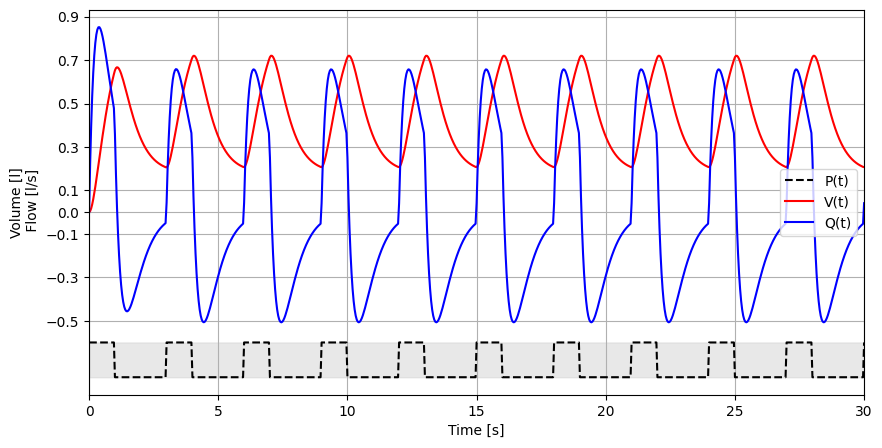

In [120]:
def model(t, x, params):
    
    V = x[0]
    Q = x[1]

    E1 = params[0]
    R1 = params[1]
    E2 = params[2]
    R2 = params[3]
    Rc = params[4]
    P = params[5](t)

    dV = Q
    dQ = ( (E1 + E2) * P - ((R2 + Rc)*E1 +(R1+Rc)*E2)*Q - E1*E2*V ) / (R1*R2 + Rc*(R1+R2))



    return [dV, dQ]

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

def simulate_cycle(t, P, params, initial_conditions):
    P = interp1d(t, P, kind='linear', fill_value='extrapolate')
    params.append(P)
    t_span = [min(t), max(t)]
    sol = solve_ivp(model, t_span, initial_conditions, args=(params,), t_eval=t, max_step=0.04)
    return sol

t = np.arange(0, 30.001, 0.04)
P = [square_wave(x) for x in t]
params = [med_control_properties.loc[0.5, 'Ers'], med_control_properties.loc[0.5, 'Rrs'], med_control_properties.loc[0.5, 'Ers'], med_control_properties.loc[0.5, 'Rrs'], 5]
initial_conditions = [0, 0]
print(params)
sol = simulate_cycle(t, P, params, initial_conditions)
# Calculate min and max of scaled P(t)
f = 0.2
y_offset = 0.8
scaled_P = [f*p/np.max(P) - y_offset for p in P]
min_scaled_P = min(scaled_P)
max_scaled_P = max(scaled_P)

# Plotting dashed P(t) with background fill
plt.figure(figsize=(10, 5))
plt.fill_between(t, min_scaled_P, max_scaled_P, color='lightgrey', alpha=0.5)
plt.plot(t, scaled_P, 'k--', label='P(t)')

plt.plot(sol.t, sol.y[0], label='V(t)', color='r')
plt.plot(sol.t, sol.y[1], label='Q(t)', color='b')

plt.xlim(min(t), max(t))

plt.xlabel('Time [s]')
plt.ylabel('Volume [l]\n Flow [l/s]')
plt.grid()

plt.legend(loc='best')
# Set y ticks from -0.5 to 0.9 with a step size of 0.1
plt.gca().set_yticks(list(np.arange(-0.5, 1.0, 0.2)) + [0])

plt.show()